In [ ]:
import math
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torchvision import transforms, datasets
from torch import optim
from torchnet import meter
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt

# 模型输入参数，需要自己根据需要调整
num_class = 20  # 分类数
epochs = 20  # 迭代次数
batch_size = 96  # 每个批次样本大小
lr = 0.0003  # 学习率
image_path = './train'  # 图像数据路径
save_path = './best_model.pkl'  # 模型保存路径
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # 设备

# 1.数据转换
data_transform = {
    # 训练中的数据增强和归一化
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),  # 随机裁剪
        transforms.ToTensor(),  # 均值方差归一化
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 2.形成训练集
train_dataset = datasets.ImageFolder(root=os.path.join(image_path),
                                     transform=data_transform['train'])

# 3.形成迭代器
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size,
                                           True)

print('using {} images for training.'.format(len(train_dataset)))

# 4.建立分类标签与索引的关系
cloth_list = train_dataset.class_to_idx
class_dict = {}
for key, val in cloth_list.items():
    class_dict[val] = key
with open('class_dict.pk', 'wb') as f:
    pickle.dump(class_dict, f)


class LeNet5(nn.Module):
    def __init__(self, num_class):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool1 = nn.AvgPool2d((2, 2))

        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool2 = nn.AvgPool2d((2, 2))

        self.conv3 = nn.Conv2d(16, 32, 5)

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(28800, 1024)
        self.fc2 = nn.Linear(1024, num_class)

    def forward(self, x):
        # x: torch.Size([32, 3, 150, 150])

        x = self.conv1(x)  # torch.Size([32, 8, 146, 146])
        x = self.relu(x)
        x = self.pool1(x)  # torch.Size([32, 8, 73, 73])

        x = self.conv2(x)  # torch.Size([32, 16, 69, 69])
        x = self.relu(x)
        x = self.pool2(x)  # torch.Size([32, 16, 34, 34])

        x = self.conv3(x)  # torch.Size([32, 32, 30, 30])
        x = self.relu(x)

        x = x.flatten(start_dim=1)  # torch.Size([32, 28800])

        x = self.fc1(x)  # torch.Size([32, 2024])
        x = self.relu(x)
        x = self.fc2(x)  # torch.Size([32, 4])

        return x


# 6.模型训练
model = LeNet5(num_class)
model = model.to(device)
criterion = nn.CrossEntropyLoss()  # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 优化器
running_loss_plot = []
epoch_acc_plot = []

best_acc = 0  # 最优精确率
best_model = None  # 最优模型参数

for epoch in range(epochs):
    model.train()
    running_loss = 0  # 损失
    epoch_acc = 0  # 每个epoch的准确率
    epoch_acc_count = 0  # 每个epoch训练的样本数
    train_count = 0  # 用于计算总的样本数，方便求准确率
    train_bar = tqdm(train_loader)
    for data in train_bar:
        images, labels = data
        optimizer.zero_grad()
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)
        # 计算每个epoch正确的个数
        epoch_acc_count += (output.argmax(axis=1) == labels.view(-1)).sum()
        train_count += len(images)

    # 每个epoch对应的准确率
    epoch_acc = epoch_acc_count / train_count

    # 打印信息
    print("【EPOCH: 】%s" % str(epoch + 1))
    print("训练损失为%s" % str(running_loss))
    print("训练精度为%s" % (str(epoch_acc.item() * 100)[:5]) + '%')
    running_loss_plot.append(running_loss)
    epoch_acc_plot.append(epoch_acc)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = model.state_dict()

    # 在训练结束保存最优的模型参数
    if epoch == epochs - 1:
        # 保存模型
        torch.save(best_model, save_path)

print("最优精度为%s" % (str(best_acc.item() * 100)[:5]) + '%')
print('Finished Training')
plt.figure()
plt.plot(epoch_acc_plot,'b',label = 'epoch_acc_loss')
plt.ylabel('epoch_acc_loss')
plt.xlabel('iter_num')
plt.legend()

plt.figure()
plt.plot(running_loss_plot,'r',label = 'running_loss')
plt.ylabel('running_loss')
plt.xlabel('iter_num')
plt.legend()

using 84022 images for training.


train epoch[1/20] loss:2.021: 100%|██████████| 876/876 [13:20<00:00,  1.09it/s]


【EPOCH: 】1
训练损失为1741.0019246339798
训练精度为35.87%


train epoch[2/20] loss:1.408: 100%|██████████| 876/876 [14:37<00:00,  1.00s/it]


【EPOCH: 】2
训练损失为1266.013860464096
训练精度为52.55%


train epoch[3/20] loss:1.089: 100%|██████████| 876/876 [14:46<00:00,  1.01s/it]


【EPOCH: 】3
训练损失为1078.2166528105736
训练精度为59.45%


train epoch[4/20] loss:1.055: 100%|██████████| 876/876 [14:57<00:00,  1.02s/it]


【EPOCH: 】4
训练损失为977.1033856272697
训练精度为63.15%


train epoch[5/20] loss:0.588: 100%|██████████| 876/876 [14:35<00:00,  1.00it/s]


【EPOCH: 】5
训练损失为909.2725114226341
训练精度为65.81%


train epoch[6/20] loss:0.905: 100%|██████████| 876/876 [14:36<00:00,  1.00s/it]


【EPOCH: 】6
训练损失为864.9167885780334
训练精度为67.34%


train epoch[7/20] loss:1.452: 100%|██████████| 876/876 [14:39<00:00,  1.00s/it]


【EPOCH: 】7
训练损失为817.0662642717361
训练精度为69.22%


train epoch[8/20] loss:0.840: 100%|██████████| 876/876 [14:36<00:00,  1.00s/it]


【EPOCH: 】8
训练损失为779.7310253977776
训练精度为70.73%


train epoch[9/20] loss:0.771:  79%|███████▉  | 690/876 [4:05:45<05:53,  1.90s/it]      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(92, 96, 3)


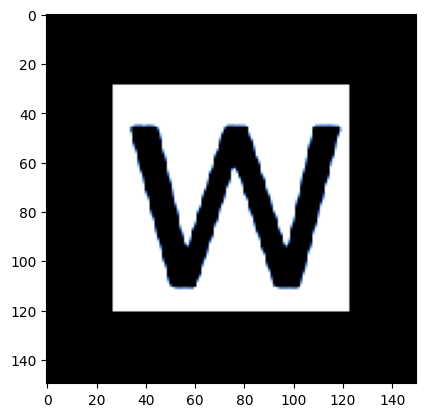

【预测结果分类】：Arial


In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# 加载索引与标签映射字典
with open('class_dict.pk', 'rb') as f:
    class_dict = pickle.load(f)

# 数据变换
data_transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# 图片路径
img_path = r'./test1/TA1.png'

# 打开图像
img = Image.open(img_path).convert('RGB')
print(np.array(img).shape)

# 对图像进行变换
img = data_transform(img)

plt.imshow(img.permute(1, 2, 0))
plt.show()

# 将图像升维，增加batch_size维度
img = torch.unsqueeze(img, dim=0)

# 获取预测结果
pred = class_dict[model(img).argmax(axis=1).item()]
print('【预测结果分类】：%s' % pred)